# Deep Learning: Construct and Run a PICNN to Predict Sea Ice Concentration (SIC)

This notebook walks through the data loading and preparation for input into a physically-informed convolutional neural network (PICNN) to predict a given year's sea ice concentration (SIC) map and compare the performance to the actual SIC map. The input data includes both SIC and sea surface temperature (SST) from 1979-2024, given the annual-to-annual memory stored in SIC and the direct thermodynamic relationship between SIC and SST.

In [2]:
# Load libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from scipy.stats import pearsonr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Step 1. Load and preprocess the data

The data is loaded from the AI-ready .nc file located in the `data` folder of the cloned git repository. Make sure to change the `home_path` below to the directory you cloned the `MLGEO2024_SeaIcePrediction` repository into so that the data file can be found without error.

In [3]:
# Edit this to your home directory this repository was cloned into
home_path = "/global/u2/s/skygale/"

In [4]:
def load_data(file_path):
    """
    Function to load the data from the .nc file.
    """
    data = xr.open_dataset(file_path)
    lat = data.latitude.values
    lon = data.longitude.values
    sic_data = data["sic"][:, ::-1]
    sst_data = data["sst"][:, ::-1]
    return sic_data, sst_data, lat, lon

def preprocess_data(sic_data, sst_data):
    """
    Function to apply land mask and remove NaNs to clean data, followed by normalization.
    """
    # Mask out land (values > 1)
    sic_data = sic_data.where(sic_data <= 1)  # Keep only sea areas (sic <= 1)
    
    # Fill NaNs with 0
    sic_data = sic_data.fillna(0)
    sst_data = sst_data.fillna(0)
    
    # Normalize the sic and sst data to be between 0 and 1
    scaler = MinMaxScaler()
    sic_data_normalized = scaler.fit_transform(sic_data.values.reshape(-1, sic_data.shape[-1])).reshape(sic_data.shape)
    sst_data_normalized = scaler.fit_transform(sst_data.values.reshape(-1, sst_data.shape[-1])).reshape(sst_data.shape)

    return sic_data_normalized, sst_data_normalized

# Load and preprocess data
file_path = str(home_path) + "MLGEO2024_SeaIcePrediction/data/ready_sic_sst_data.nc"
sic_data, sst_data, lat, lon = load_data(file_path)
sic_data, sst_data = preprocess_data(sic_data, sst_data)

### Step 2. Split the data into training, testing, and validation

The data is split into ~70% training, 20% testing, and ~10% validation. These percentages are based off of the 46 years of data provided so that the most recent year (2024) is the test year. The data splits are not shuffled to ensure chronological training and testing data.

In [5]:
def split_data(sic_data, sst_data, test_size=0.2, validation_size=0.1):
    """
    Function to split data into training, validation, and test sets.
    """
    # Combine the data for input (time, lat, lon, 2)
    combined_data = np.moveaxis([sic_data, sst_data], 0, -1)

    # Split the data into training and remaining (validation + test)
    X_train, X_remaining, y_train, y_remaining = train_test_split(
        combined_data,  # Combine SST and SIC for input
        sic_data,  # SIC data as target
        test_size=test_size, random_state=42, shuffle=False
    )

    # Further split remaining data into validation and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_remaining, y_remaining,
        test_size=validation_size, random_state=42, shuffle=False
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Splitting data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(sic_data, sst_data)

# Print shapes to check
print("X_train shape:", X_train.shape)
print("X_val shape:  ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:  ", y_val.shape)
print("y_test shape: ", y_test.shape)

X_train shape: (36, 160, 1440, 2)
X_val shape:   (9, 160, 1440, 2)
X_test shape:  (1, 160, 1440, 2)
y_train shape: (36, 160, 1440)
y_val shape:   (9, 160, 1440)
y_test shape:  (1, 160, 1440)


### Step 3. Build the PICNN

This PICNN will be quite simple due to the direct relationship between SIC and SST. In other words, deeper layers are not necessary to extract the needed information to make a well-informed prediction later on. We implement a thermodynamic physical constraint and a SIC saturation constraint to the CNN for physicallity. The thermodynamic constraint ensures there is no sea ice predicted where the SST is greater than freezing point temperature, and the saturation constraint stops SIC from being predicted at values below 0 or above 1.

In [74]:
def thermodynamic_constraint_loss(y_pred, sst, freezing_point=-1.8):
    """
    Function to add a penalty for SIC predictions when SST is above the freezing point.
    """
    melt_mask = tf.cast(sst > freezing_point, tf.float32)  # Mask for SST > -1.8
    violation = y_pred * melt_mask  # Penalize SIC > 0 where SST > freezing_point
    return tf.reduce_mean(tf.square(violation))  # Mean squared penalty

def combined_loss(y_true, y_pred, sst, lambda_physics=1.0):
    """
    Function to combine MSE loss with thermodynamic constraint loss.
    """
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Data loss
    physics_loss = thermodynamic_constraint_loss(y_pred, sst)  # Physics loss
    return mse_loss + lambda_physics * physics_loss

def create_model(input_shape):
    """
    Function to create the neural network.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(160 * 1440, activation='sigmoid'),  # Add sigmoid activation for physical constraints
        layers.Reshape((160, 1440))  # Reshape the output to match (160, 1440)
    ])
    return model

In [75]:
# Compile the model with a custom training step
class PhysicsInformedModel(tf.keras.Model):
    def __init__(self, model, lambda_physics=1.0):
        super().__init__()
        self.model = model
        self.lambda_physics = lambda_physics
        
    def call(self, inputs, training=False):
        sic, sst = inputs[..., 0], inputs[..., 1]  # Extract SIC and SST
        y_pred = self.model(inputs, training=training)  # Get SIC prediction from the base model

        if training:
            # During training, calculate the loss, including the physics constraint
            loss = combined_loss(sic, y_pred, sst, self.lambda_physics)
            self.add_loss(loss)  # Add the custom loss to the model's total loss

        return y_pred

    def train_step(self, data):
        X, y = data
        sic, sst = X[..., 0], X[..., 1]  # Split SIC and SST from input

        with tf.GradientTape() as tape:
            y_pred = self.model(X, training=True)
            loss = combined_loss(y, y_pred, sst, self.lambda_physics)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        X, y = data
        sic, sst = X[..., 0], X[..., 1]  # Split SIC and SST from input
        y_pred = self.model(X, training=False)
        loss = combined_loss(y, y_pred, sst, self.lambda_physics)
        return {"loss": loss}

# Create and compile the PICNN
input_shape = X_train.shape[1:]  # (lat, lon, SIC and SST)
base_model = create_model(input_shape)
physics_model = PhysicsInformedModel(base_model, lambda_physics=1.0)
physics_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary to verify the architecture
base_model.summary()
physics_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 158, 1438, 32)  │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 79, 719, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 77, 717, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 38, 358, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 870656)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    55,722,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 230400)         │    14,976,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 160, 1440)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,717,152 (269.76 MB)

 Trainable params: 70,717,152 (269.76 MB)

 Non-trainable params: 0 (0.00 B)

Model: "physics_informed_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 160, 1440)      │    70,717,152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,717,152 (269.76 MB)

 Trainable params: 70,717,152 (269.76 MB)

 Non-trainable params: 0 (0.00 B)

### Step 4. Train the PICNN

The PICNN is trained and validated on the training data. The user can input values for the number of epochs and batch size used in training to increase model performance.

In [77]:
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    """
    Function to train the model with a given number of epochs and batch_size.
    """
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
    )
    return history

def plot_loss(history, train_loss, figure_name):
    """
    Function to plot training and validation loss per epoch.
    """
    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(train_loss, linewidth=2)
    
    # Add title and labels
    plt.title('Training Loss Per Epoch', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Display and save the plot
    plt.tight_layout()
    plt.savefig(
        f"{str(home_path)}/MLGEO2024_SeaIcePrediction/notebooks/figures/{str(figure_name)}",
        dpi=300, bbox_inches='tight'
    )
    plt.show()

# Can edit these parameters based on model performance
epochs = 10
batch_size = 32

# Train the model
history = train_model(physics_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0957 - val_loss: 0.0000e+00
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0922 - val_loss: 0.0000e+00
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0938 - val_loss: 0.0000e+00
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0877 - val_loss: 0.0000e+00
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0890 - val_loss: 0.0000e+00
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0892 - val_loss: 0.0000e+00
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0906 - val_loss: 0.0000e+00
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0866 - val_loss: 0.0000e+00
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0979 - val_loss: 0.0000e+00
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0916 - val_loss: 0.0000e+00


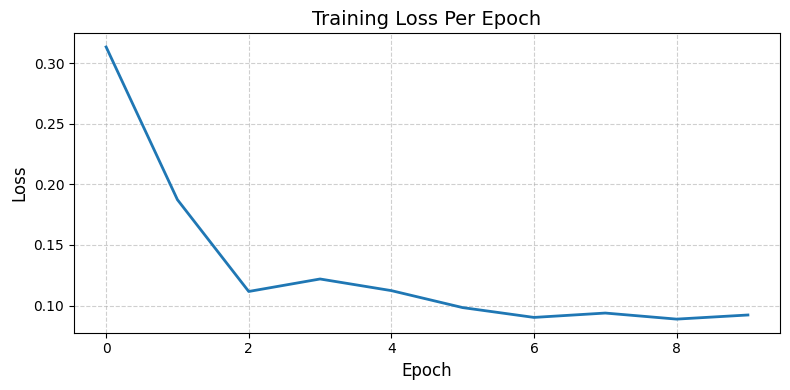

In [20]:
# Plot the loss per epoch
plot_loss(history, train_loss=history.history['loss'], figure_name="loss_per_epoch.png")

### Step 5. Evaluate the trained model with the test data

We can calculate many metrics, but for simplicity we will look at the RMSE and Pearson Correlation Coefficient between the predicted SIC map and the actual SIC map for the chosen test year.

In [78]:
def evaluate_model(model, X_test, y_test):
    """
    Function to evaluate the physics-informed model on the test set.
    """
    # Evaluate the model on the test set (compute total loss including physics constraints)
    test_metrics = model.evaluate(X_test, y_test, return_dict=True)
    test_loss = test_metrics.get("loss", float("nan"))
    
    # If the loss includes physics constraints, compute RMSE using predicted and actual SIC
    y_pred = model.predict(X_test)
    mse_loss = np.mean((y_test - y_pred) ** 2)  # Manually compute MSE
    rmse = np.sqrt(mse_loss)  # Compute RMSE
    print(f"Test Loss (from model): {test_loss:.3f}")
    print(f"Computed RMSE (from predictions): {rmse:.3f}")
    
    # Extract the first sample (or any sample of interest) from the test set
    actual_sic = y_test[0]  # Actual SIC map for the first test sample
    pred_sic = y_pred[0]  # Predicted SIC map for the first test sample
    
    # Flatten and filter out NaN values for the correlation calculation
    valid_mask = ~np.isnan(actual_sic) & ~np.isnan(pred_sic)
    actual_flat = actual_sic[valid_mask].flatten()
    pred_flat = pred_sic[valid_mask].flatten()

    # Calculate the correlation coefficient (Pearson)
    if len(actual_flat) > 1:  # Ensure there are enough valid points
        corr, _ = pearsonr(actual_flat, pred_flat)
    else:
        corr = float("nan")  # Not enough data for correlation
    print(f"Computed R2 (from predictions): {corr*corr:.2f}")
    
    return actual_sic, pred_sic, rmse, corr

# Evaluate the physics-informed model
actual_sic, predicted_sic, rmse, corr = evaluate_model(physics_model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step - loss: 0.0461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Test Loss (from model): 0.000
Computed RMSE (from predictions): 0.195
Computed R2 (from predictions): 0.88


### Step 6. Plot the SIC maps of the test year for the actual and predicted concentrations for visual comparison

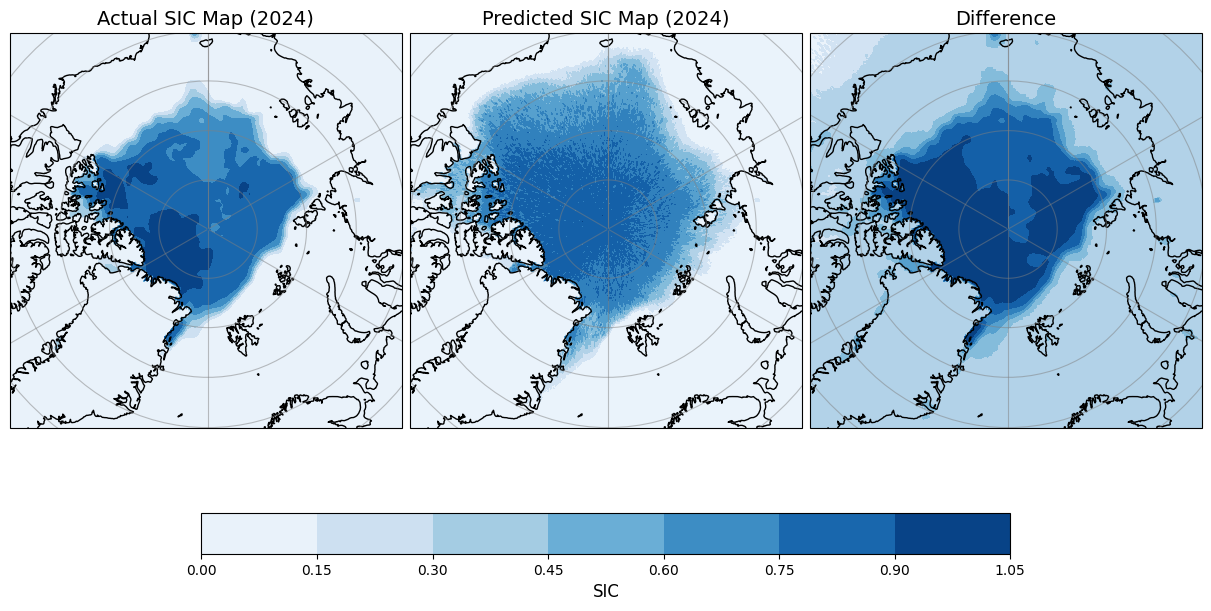

In [92]:
def predict_and_plot(actual_sic, predicted_sic, figure_name):
    """
    Function to predict test year and plot comparison.
    """
    # Replace NaN values with a placeholder (e.g., 0)
    predicted_sic = np.nan_to_num(predicted_sic, nan=0.0)

    # Create a figure with North Polar Stereo projection
    fig, axes = plt.subplots(1, 3, figsize=(12, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()}, constrained_layout=True)
    
    # Set the extent to focus on the Northern Hemisphere (60N and above)
    axes[0].set_extent([0, 360, 70, 90], crs=ccrs.PlateCarree())
    axes[1].set_extent([0, 360, 70, 90], crs=ccrs.PlateCarree())
    axes[2].set_extent([0, 360, 70, 90], crs=ccrs.PlateCarree())

    # Plot actual SIC map
    actual_plot = axes[0].contourf(
        lon, lat, actual_sic[::-1],
        cmap='Blues', transform=ccrs.PlateCarree()
    )
    axes[0].set_title('Actual SIC Map (2024)', fontsize=14)
    axes[0].coastlines(resolution="50m")
    axes[0].add_feature(cfeature.LAND)
    axes[0].gridlines(draw_labels=False, crs=ccrs.PlateCarree(), color='gray', alpha=0.5)

    # Plot predicted SIC map
    predicted_plot = axes[1].contourf(
        lon, lat[::-1], predicted_sic,
        cmap='Blues', transform=ccrs.PlateCarree()
    )
    axes[1].set_title('Predicted SIC Map (2024)', fontsize=14)
    axes[1].coastlines(resolution="50m")
    axes[1].add_feature(cfeature.LAND)
    axes[1].gridlines(draw_labels=False, crs=ccrs.PlateCarree(), color='gray', alpha=0.5)
    
    # Plot difference
    difference_plot = axes[2].contourf(
        lon, lat, actual_sic[::-1]-predicted_sic,
        cmap='Blues', transform=ccrs.PlateCarree()
    )
    axes[2].set_title('Difference', fontsize=14)
    axes[2].coastlines(resolution="50m")
    axes[2].add_feature(cfeature.LAND, color='lightgrey')
    axes[2].gridlines(draw_labels=False, crs=ccrs.PlateCarree(), color='gray', alpha=0.5)

    # Add a shared colorbar below the plots
    cbar = fig.colorbar(
        actual_plot, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1
    )
    cbar.set_label('SIC', fontsize=12)

    # Save and show the plot
    plt.savefig(
        f"{str(home_path)}/MLGEO2024_SeaIcePrediction/notebooks/figures/{str(figure_name)}",
        dpi=300, bbox_inches='tight'
    )
    plt.show()
    
# Predict on test year and plot results
predict_and_plot(actual_sic, predicted_sic, figure_name="actual_vs_prediction_maps.png")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 10), constrained_layout=True)

axs[0].contourf(actual_sic, cmap='Blues')
axs[1].contourf(predicted_sic, cmap='Blues')
axs[2].(actual_sic-predicted_sic, cmap='Blues')

plt.show()